# <center><b>CNN for Alzheimer's Detection From MRI Images</b></center>

# INTRODUCTION
Alzheimer’s disease (AD) is a neurological disorder that results in diminished cognitive function. AD onset most often occurs when people are in their mid 60s and is the most frequent cause of dementia in seniors. It is currently estimated that over 6 million American’s over 65 have AD [4]. There are currently no cures for AD, however there are some treatment strategies. Early detection and intervention have been shown to slow disease progression and improve the quality of life for individuals suffering from AD [3]. Definitively diagnosing AD while someone is alive remains a challenge for the medical community and several metrics need to be assessed to determine if an individual is suffering from AD [2]. These methods may include brain scans such as magnetic resonance imaging (MRI), cognitive assessments through testing of memory, attention and problem solving, overall health assessment, and examining environmental and biological factors [2]. Developing models that help detect early-stage AD would be a great help to those suffering from the disease. The focus of this project will be to build a convolutional neural network (CNN) to detect AD in MRI scans. 

# LIBRARIES

In [2]:
import os
import numpy as np 
import pandas as pd 
import math
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# DATA EXPLORATION AND PROCESSING
The dataset used for this project consists of images from MRI brain scans. The MRI technique is non-invasive and can produce detailed images of soft tissue such as brain tissue [1]. Changes in brain structure such as cerebral atrophy (shrinking of the brain), and abnormal protein build up are characteristics of AD [2]. The data is comprised of four classes, Non-Demented, Mild Demented, Moderate Demented, and Very Mild Demented. The data is preprocessed so little cleaning needs to be done. However, the images will still be normalized using a data generator. There is a class imbalance in the data with only 64 images associated with moderate dementia. 

**Alzheimer MRI Preprocessed Dataset Available at Kaggle**
https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset


## Directories

In [3]:
# Input data files are available in the read-only "../input/" directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/alzheimer-mri-dataset
/kaggle/input/alzheimer-mri-dataset/Dataset
/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented
/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented
/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented
/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented


In [4]:
directory =  "/kaggle/input/alzheimer-mri-dataset/Dataset"
train_dir = directory + "/train"
validation_dir = directory + "/validation"

### Check Categories

In [5]:
classes = os.listdir("/kaggle/input/alzheimer-mri-dataset/Dataset")
print(classes)

['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']


### Check Number of Images per Category

In [6]:
for c in classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(directory, c))), 'images')

* Non_Demented = 3200 images
* Mild_Demented = 896 images
* Moderate_Demented = 64 images
* Very_Mild_Demented = 2240 images


## Data Generator
Normalize the pixel values of the images by dividing them by 255 ensuring that the pixel values are in the range [0, 1] instead of [0, 255]. Also, splits the data into testing and validation sets. 

In [7]:
# Create ImageDataGenerator objects
datagen = ImageDataGenerator(validation_split=0.30, rescale=1./255)

# Training data generator
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(256, 256), # Resize images to 256x256 pixels
    batch_size=32,
    class_mode='categorical', # For multi-class classification
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    directory,
    target_size=(256, 256), # Resize images to 256x256 pixels
    batch_size=32,
    class_mode='categorical', # For multi-class classification
    subset='validation'
)

Found 4481 images belonging to 4 classes.
Found 1919 images belonging to 4 classes.


## Display Example Images

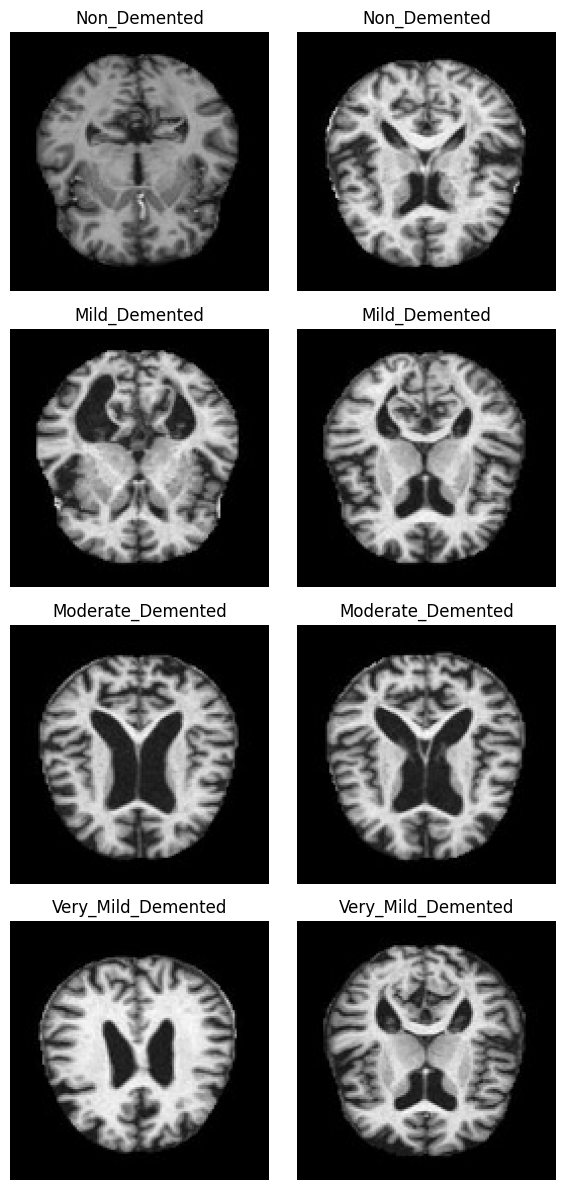

In [8]:
num_images_display = 2

# Initialize plot
fig, axes = plt.subplots(len(classes), num_images_display, figsize = (num_images_display * 3, len(classes) * 3))

# Loop to get images from each class
for i, class_name in enumerate(classes):
    class_dir = os.path.join(directory, class_name)
    images = os.listdir(class_dir)[:num_images_display]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = image.load_img(img_path, target_size =(256, 256))
        img_array = image.img_to_array(img)/ 255.0
        
        ax = axes[i, j]
        ax.imshow(img_array)
        ax.axis('off')
        ax.set_title(f"{class_name}")
        
plt.tight_layout()
plt.savefig('example_mri.png')
plt.show()

# MODELS
CNNs will be used to detect AD in brain tissue by analyzing MRI images. CNNs are an appropriate choice for this task for several reasons. For one they use convolutional layers with local receptive fields to recognize patterns such as edges, textures and shape. Given the changes in brain structure associated with AD [2], detecting patterns such as these could be helpful in diagnosing the disease. CNNs process images through multiple layers, they learn to extract increasingly complex features. Early layers detect simple structures, while deeper layers can capture more complex patterns, such as those associated with cerebral atrophy and protein build-up. 

### Data Augmentation
Data augmentation helps prevent overfitting by generating diverse training samples. This is done by randomly rotating, flipping, zooming or adjusting the contrast of some images. Defining the augmentation this way will allow for it to be easily take in and out of models if required.

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

## Learning Rate Scheduler
This scheduler will be used to decrease the learning rate during model training. 

In [10]:
def step_decay(epoch, lr):
    initial_lr = 1.0  # Set initial learning 
    decay_factor = 0.5  # Set  decay factor 
    decay_step = 2  # Set the number of epochs after which to decay

    if epoch != 0 and epoch % decay_step == 0:
        lr *= decay_factor
    return lr

### Performance Plot Function
Plots the accuracy, loss and auc scores from model training history.

In [11]:
def model_performance_plots(history, model_name):
    """
    Plot the accuracy, loss, and auc score from the training history.
    Inputs: 
    history - the history of the fit method of the model
    model_name - the name of the model
    """

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend(loc='upper right')

    # AUC Score plot
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title(f'{model_name} AUC')
    plt.legend(loc='lower right')

    plt.tight_layout()


## First Model Architecture

**Convolutional Layers:** capture spatial hierarchies in the data

Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)): The first convolutional layer with 32 filters of size 3x3, using ReLU activation The input shape is 256x256 with 3 channels (RGB).

Conv2D(64, (3, 3), activation='relu'): The second convolutional layer with 64 filters. X 2

Conv2D(128, (3, 3), activation='relu'): The third convolutional layer with 128 filters.X 2

**Max Pooling:**

MaxPooling2D((2, 2)) reduces the spatial dimensions by half, and helps the model focus on the most important features.

**Dropout:**  

Dropout(0.3): Applied before the final dense layer, to help prevent overfitting.

**Flatten:** 

converts 3D tensor into a 1D vector

**Dense Layers:**

Dense(256): A fully connected layer with 256 units. Larger dense layer can learn more complex and abstract features from the data allowing the model to capture more detailed information and interactions.

Dense(4, activation='softmax'): The output layer with 4 units (since it’s a 4-class classification problem) and softmax activation to output class probabilities.

In [13]:
model_basic = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4 classes for multi-class classification
])


In [14]:
model_basic.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'auc'])

model_basic.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 123, 123, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,969,156 (99.06 MB)

 Trainable params: 25,969,156 (99.06 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_basic = model_basic.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=7 
)

Epoch 1/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.9024 - auc: 0.9862 - loss: 0.2672 - val_accuracy: 0.4320 - val_auc: 0.7095 - val_loss: 2.5012
Epoch 2/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.9576 - auc: 0.9972 - loss: 0.1166 - val_accuracy: 0.4997 - val_auc: 0.7222 - val_loss: 4.0302
Epoch 3/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.9744 - auc: 0.9987 - loss: 0.0735 - val_accuracy: 0.5367 - val_auc: 0.7620 - val_loss: 3.2487
Epoch 4/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.9838 - auc: 0.9992 - loss: 0.0469 - val_accuracy: 0.4789 - val_auc: 0.7158 - val_loss: 3.4355
Epoch 5/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.9870 - auc: 0.9994 - loss: 0.0413 - val_accuracy: 0.5237 - val_auc: 0.7433 - val_loss: 4.2166
Epoch 6/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.9919 - auc: 0.9998 - loss: 0.0219 - val_accuracy: 0.4935 - val_auc: 0.7089 - val_loss: 5.3117
Epoch 7/7
141/141 ━━━━━━━━━━

## First Model Results
Although the basic model performed well on the training data it did not do well with the validation data. The loss for the validation data increased with the epochs, indicating a problem with overfitting. To address overfitting dropout layers will be added and batch normalization layers will be added to help stabilize the model. 


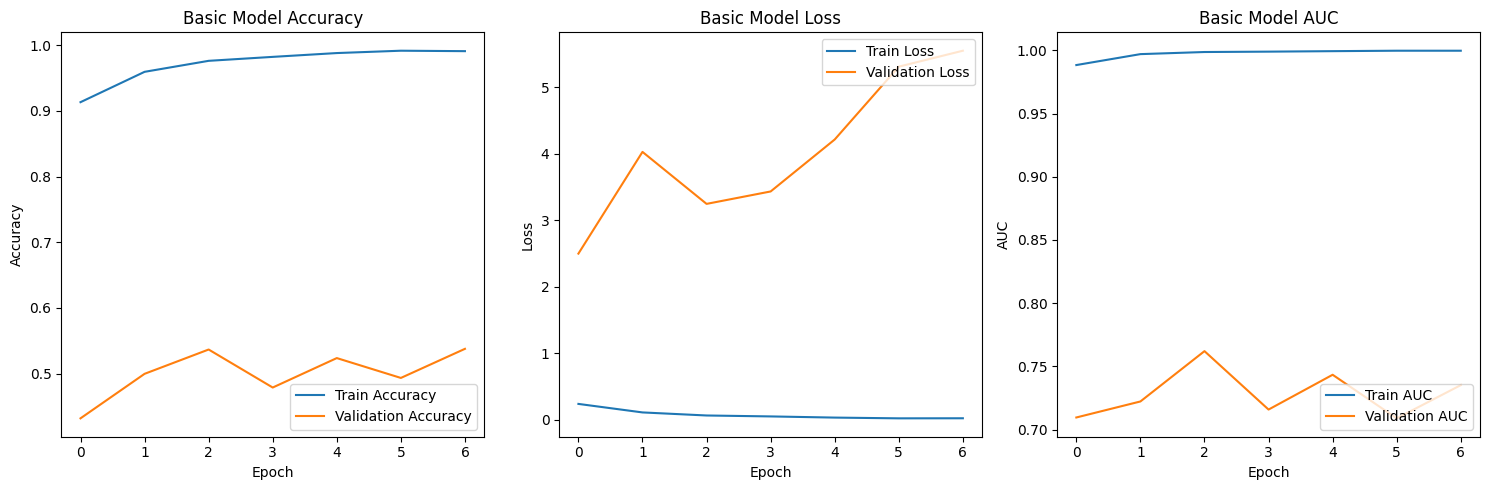

In [18]:
# Plot results
model_basic_plots = model_performance_plots(history_basic, "Basic Model")
plt.savefig("/kaggle/working/basic_model_plots.jpg")
plt.show()

## Second Model Architecture

**Convolutional Layers:** capture spatial hierarchies in the data

Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)): The first convolutional layer with 32 filters of size 3x3, using ReLU activation, with padding to keep the dimensions the same as the input. The input shape is 256x256 with 3 channels (RGB).

Conv2D(64, (3, 3), activation='relu',padding='same'): The second convolutional layer with 64 filters. X 2

Conv2D(128, (3, 3), activation='relu',padding='same'): The third convolutional layer with 128 filters. X 2


**Batch Normalization:**

Added after each convolutional layer to normalize the activations, stabilize the learning process, and potentially reduce overfitting.

**Max Pooling:**

MaxPooling2D((2, 2)) reduces the spatial dimensions by half, and helps the model focus on the most important features.

**Dropout:** 

Dropout(0.2): Randomly sets 20% of the input units to 0 during training, which helps prevent overfitting.

Dropout(0.3): Applied before the dense layers, with a higher dropout rate to prevent overfitting as the model becomes more complex.

**Flatten:** 

converts 3D tensor into a 1D vector

**Dense Layers:**

Dense(256): A fully connected layer with 256 units. Larger dense layer can learn more complex and abstract features from the data allowing the model to capture more detailed information and interactions.

Dense(4, activation='softmax'): The output layer with 4 units (since it’s a 4-class classification problem) and softmax activation to output class probabilities.


In [20]:

model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')  # 4 classes for multi-class classification
])


In [21]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'auc'])

model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,834,372 (129.07 MB)

 Trainable params: 33,833,924 (129.07 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
learning_rate_scheduler = LearningRateScheduler(step_decay)

history2 = model2.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=7,
    callbacks=[learning_rate_scheduler]
)

Epoch 1/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 32s 220ms/step - accuracy: 0.4563 - auc: 0.7797 - loss: 1.1159 - val_accuracy: 0.4987 - val_auc: 0.8004 - val_loss: 1.2230 - learning_rate: 0.0010
Epoch 2/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.4493 - auc: 0.7965 - loss: 1.0476 - val_accuracy: 0.5003 - val_auc: 0.8021 - val_loss: 1.2110 - learning_rate: 0.0010
Epoch 3/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.4608 - auc: 0.8000 - loss: 1.0338 - val_accuracy: 0.5008 - val_auc: 0.8009 - val_loss: 1.1111 - learning_rate: 5.0000e-04
Epoch 4/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.4595 - auc: 0.8162 - loss: 0.9905 - val_accuracy: 0.5180 - val_auc: 0.8069 - val_loss: 0.9985 - learning_rate: 5.0000e-04
Epoch 5/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.4633 - auc: 0.8118 - loss: 0.9954 - val_accuracy: 0.5524 - val_auc: 0.8059 - val_loss: 1.0062 - learning_rate: 2.5000e-04
Epoch 6/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - ac

## Second Model Results
The problem with overfitting was corrected and the network was more stable. However, the accuracy was only around 50% for the training data and 55-60% for the validation data. The AUC scores for both data sets were around 0.8, which is good especially given that the data is not balanced. To try to increase the accuracy, the added dropout layers will be removed, and data augmentation will be applied to address overfitting instead. This will add some variability to the data by randomly rotating, flipping, zooming or adjusting the contrast of some images. Also, learning rate scheduling will be applied which will decrease the learning rate per epoch to prevent the model from overshooting the minimum. 


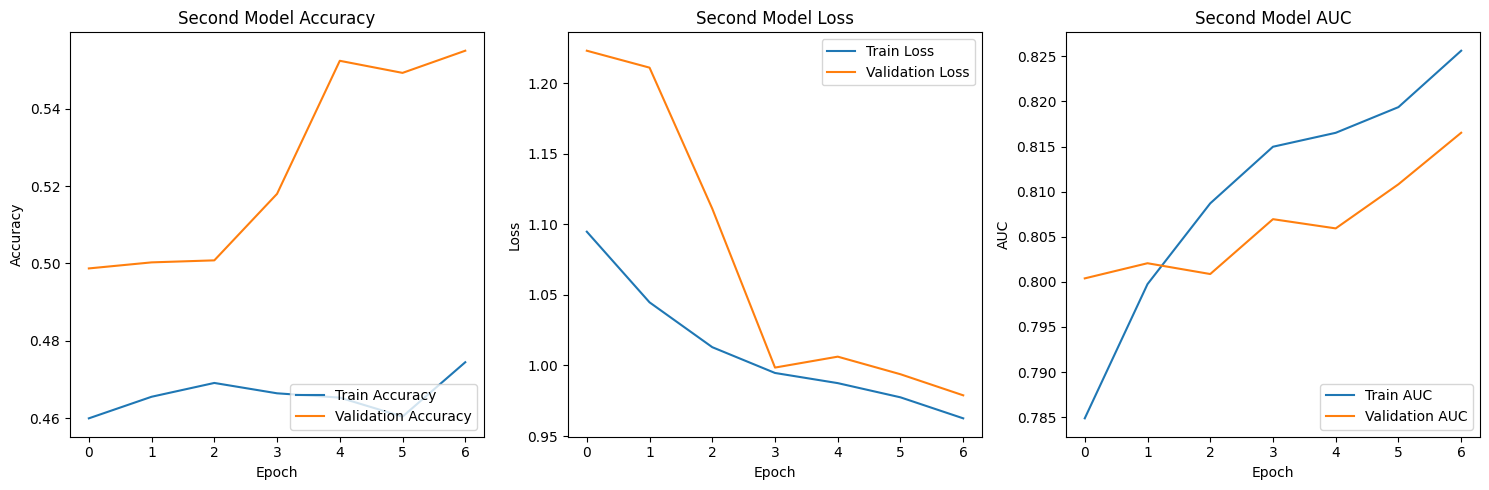

In [24]:
# Plot results
model2_plots = model_performance_plots(history2, "Second Model")
plt.savefig("/kaggle/working/second_model_plots.jpg")
plt.show()

## Third Model Architecture
This model will have the same architecture as the second model, but data augmentation will be added before the first convolution layer, and the dropout layers after the pooling layers will be removed. The dropout layer before the dense layer will remain. 

In [26]:
model3= models.Sequential([   
    data_augmentation,  # Add data augmentation layer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same' ),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same' ),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same' ),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same' ),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [28]:
model3.compile(optimizer=Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'auc'])


In [29]:
learning_rate_scheduler = LearningRateScheduler(step_decay)

history3 = model3.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=7,
    callbacks=[learning_rate_scheduler]
)

Epoch 1/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 278ms/step - accuracy: 0.4208 - auc: 0.6413 - loss: 111.3736 - val_accuracy: 0.5029 - val_auc: 0.7762 - val_loss: 1.2420 - learning_rate: 0.0050
Epoch 2/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.4823 - auc: 0.7780 - loss: 1.1084 - val_accuracy: 0.3377 - val_auc: 0.7107 - val_loss: 1.9405 - learning_rate: 0.0050
Epoch 3/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - accuracy: 0.5136 - auc: 0.8083 - loss: 1.0052 - val_accuracy: 0.5034 - val_auc: 0.7976 - val_loss: 1.3297 - learning_rate: 0.0025
Epoch 4/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - accuracy: 0.5080 - auc: 0.8170 - loss: 0.9649 - val_accuracy: 0.3502 - val_auc: 0.7311 - val_loss: 1.1769 - learning_rate: 0.0025
Epoch 5/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step - accuracy: 0.3724 - auc: 0.7423 - loss: 1.1601 - val_accuracy: 0.5154 - val_auc: 0.7882 - val_loss: 1.1194 - learning_rate: 0.0012
Epoch 6/7
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - accuracy: 0.

## Third Model Results

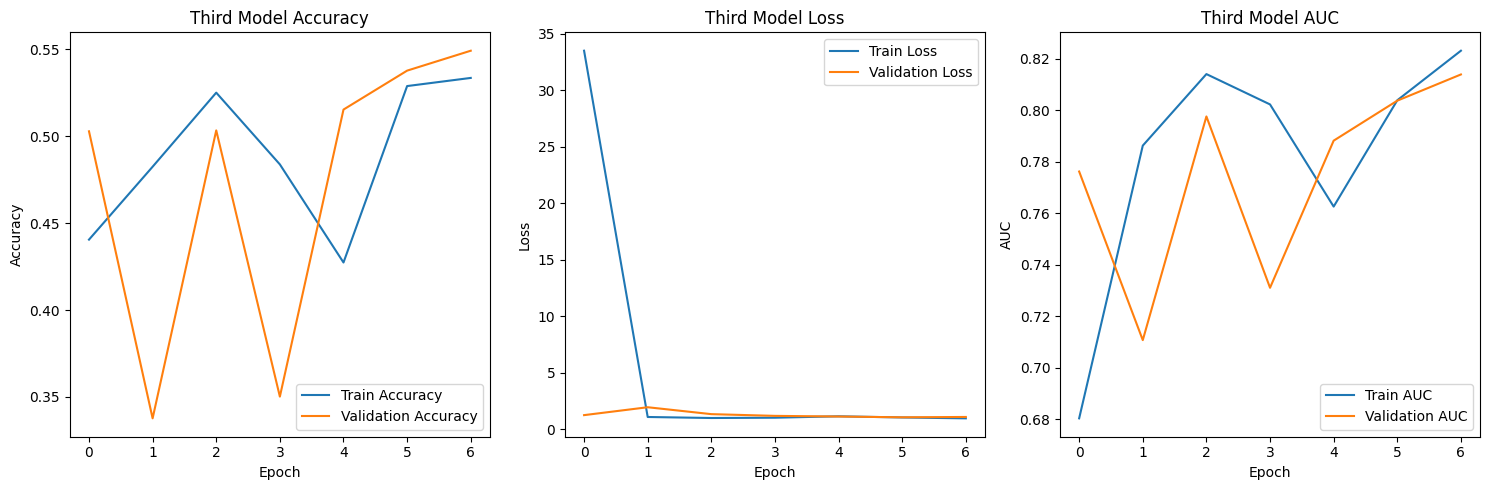

In [30]:
# Plot results
model3_plots = model_performance_plots(history3, "Third Model")
plt.savefig("/kaggle/working/third_model_plots.jpg")
plt.show()

### Confusion Matrix

In [31]:
# True labels from the validation generator
validation_labels = validation_generator.classes

# Predict the probabilities for the validation data
predictions = model3.predict(validation_generator)

# Convert the probabilities to labels
predicted_classes = np.argmax(predictions, axis=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


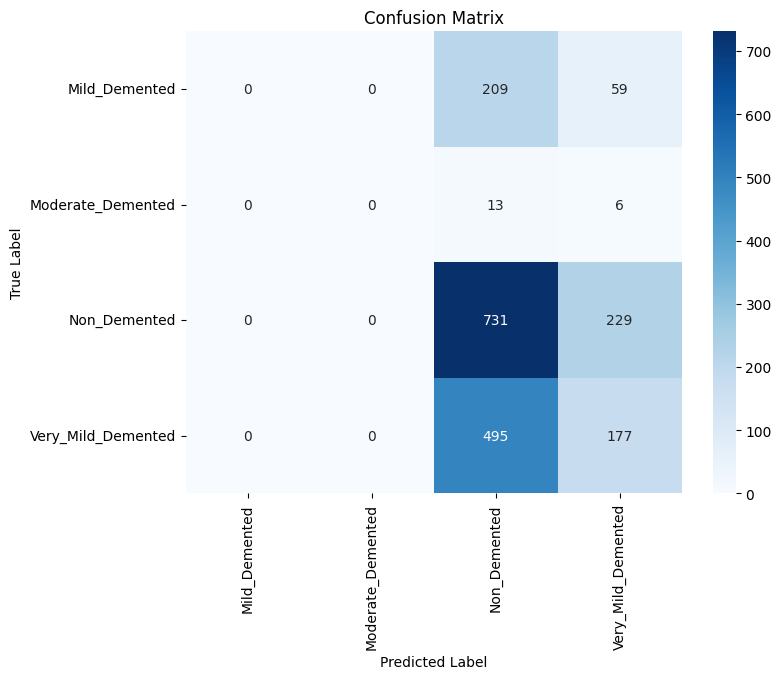

In [32]:
# Generate confusion matrix
conf_matrix3 = confusion_matrix(validation_labels, predicted_classes)

# Plot 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.savefig("/kaggle/working/third_model_confusion.jpg")
plt.show()

## Third Model Take 2
The two classes with the fewest samples are not being recognized by the model. Therefore, weight will be added to the less frequent classes to increase their importance using sklearn's compute_class_weight function. 

In [34]:
# Calculate class weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(validation_generator.classes),
    y=validation_generator.classes
)

class_weights = dict(enumerate(class_weights))

model3.compile(optimizer=Adam(learning_rate=0.05),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'auc'])



In [35]:
# Re-train the model with class weights
history3_cw = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[learning_rate_scheduler],
    class_weight=class_weights
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.4205 - auc: 0.6311 - loss: 360.6422 - val_accuracy: 0.1397 - val_auc: 0.5643 - val_loss: 1.5063 - learning_rate: 0.0500
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.0892 - auc: 0.4345 - loss: 1.4555 - val_accuracy: 0.3502 - val_auc: 0.6100 - val_loss: 1.3574 - learning_rate: 0.0500
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - accuracy: 0.1363 - auc: 0.4329 - loss: 1.5436 - val_accuracy: 0.3502 - val_auc: 0.6100 - val_loss: 1.3519 - learning_rate: 0.0250
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - accuracy: 0.1714 - auc: 0.4926 - loss: 1.4771 - val_accuracy: 0.1397 - val_auc: 0.5399 - val_loss: 1.3759 - learning_rate: 0.0250
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - accuracy: 0.1069 - auc: 0.4864 - loss: 1.3773 - val_accuracy: 0.5003 - val_auc: 0.7101 - val_loss: 1.3718 - learning_rate: 0.0125
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - accura

## Third Model Take 2 Results 

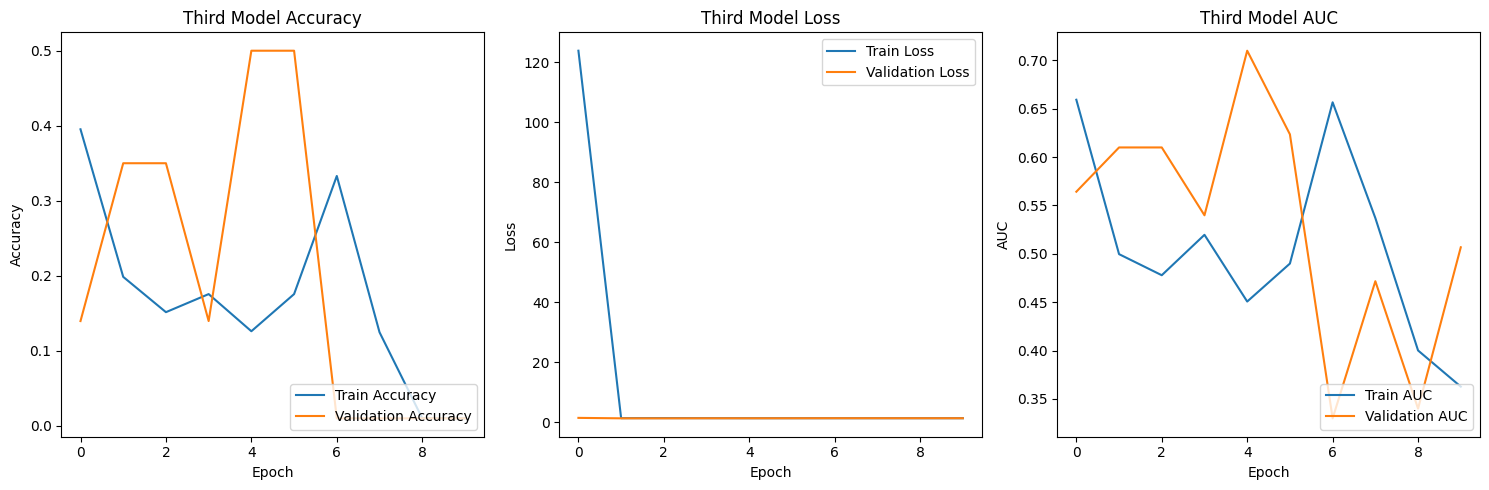

In [36]:
# Plot results
model3_cw_plots = model_performance_plots(history3_cw, "Third Model")
plt.savefig("/kaggle/working/third_cw_model_plots.jpg")
plt.show()

# CONCLUSION
Adult dementia is devastating to the individuals inflicted and their loved ones. If current population trends continue, there will be a dramatic increase in the number of people suffering from AD [5]. Deep learning techniques such as CNN could be helpful in detecting early-stage AD and directing treatments to those afflicted sooner. 

**What worked** 

There were issues with overfitting and poor AUC scores with the first model. For this dataset, which is not balanced, the AUC scores are important to look at because they evaluate the network’s ability to distinguish between positive and negative classes. Adding dropout layers or data augmentation helped correct this but the accuracy of the training data went down. 

**What didn’t Work** 

Simpler models did not work well. I started with a very simple model with 8, 16 and 32 units in the convolution layers. Although it was faster and accurate with the training data it did not work well with the validation set. This is probably because of the complexity of features in MRI data, and deeper and wider CNN architectures are needed to capture them. There were just too few samples in two of the classes, so the network had difficulty distinguishing them. 

**Improvements**

Dealing with overfitting while increasing accuracy needs to be addressed. One possible way to improve the model’s performance would be to apply transfer learning. Foster showed that using a pretrained MobileNetV2 architecture to detect AD in MRI images enhanced a deep learning model [3]. However, this was on a binary AD classification not a multi-class problem. Transfer learning could be further enhanced by implementing autotune, which helps tune hyperparameters of the pre-trained model. Continuing to tune this model could be helpful as well. Also, because of the sparsity in two of the classes, grouping all of the AD images together and dealing with this as a binary problem may be helpful.



# REFERENCES

[1] Ashby, K., Adams, B. N., & Shetty, M. (2022, November 14). Appropriate magnetic resonance imaging ordering. StatPearls - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK565857/

[2] Coupé, P., Manjón, J. V., Lanuza, E., & Catheline, G. (2019). Lifespan changes of the human brain in Alzheimer’s disease. Scientific Reports, 9(1). https://doi.org/10.1038/s41598-019-39809-8

[3] Foster, L. (2023, April 18). Identifying Alzheimer’s Disease with Deep Learning: A Transfer Learning Approach. Medium. https://medium.com/@lfoster49203/identifying-alzheimers-disease-with-deep-learning-a-transfer-learning-approach-620abf802631

[4] “How Is Alzheimer’s Disease Diagnosed?”. National Institute on Aging. Dec.08, 2022. https://www.nia.nih.gov/health/alzheimers-symptoms-and-diagnosis/how-alzheimers-disease-diagnosed

[5] Rasmussen, J., & Langerman, H. (2019). Alzheimer’s Disease – Why We Need Early    Diagnosis. Degenerative Neurological and Neuromuscular Disease, Volume 9, 123–130. https://doi.org/10.2147/dnnd.s228939

[6] “What Is Alzheimer’s Disease?”. National Institute on Aging, Jul. 08, 2021. https://www.nia.nih.gov/health/alzheimers-and-dementia/what-alzheimers-disease


Alzheimer MRI Preprocessed Dataset Available at Kaggle:
https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset
